In [5]:
import numpy as np
import png
import pydicom
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import os
import torch
import torch.nn as nn
from torchvision.transforms import Compose
import transform_classes

from roi import RoiLearn
from roi_dataset import RoiDataset
from preprocessor import Preprocessor

import preprocess_img

In [ ]:
# if we don't have the .csv file
preprocess_img.write_all_rectangle2file('O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_1\\')

In [8]:
import numpy as np
import png
import pydicom
from sklearn.preprocessing import normalize
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join
import os
import torch
import torch.nn as nn


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class RoiLearn:
    def __init__(self):
        torch.manual_seed(12)
        self.conv1 = nn.Conv2d(1,100, (11,11))
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AvgPool2d(6)
        self.flatten = Flatten()
        self.full = nn.Linear(8100,1024)
        #self.encoder = nn.Linear(121,100)
        #self.decoder = nn.Linear(100,121)
          
    # Autoencoder architecture
    def build_ae(self):
        self.autoencoder = Autoencoder(121,100)
        self.autoencoder = self.autoencoder.double()
        
    # Autoencoder W2 and b2 to the original model conv1 layer features and biases.
    # From the parameters list - index 0 is the weights
    #                          - index 1 is the biases
    def ae_weights2model_feature_set(self):
        
        w2 = list(self.encoder.parameters())
        
        b2 = w2[1].detach().numpy()
        # weights shape here (100,121)
        w2 = np.expand_dims(w2[0].detach().numpy().reshape((100,11,11)), axis = 1)
        # weights shape (100,1,11,11)
        
        conv1_features = list(self.conv1.parameters())
        conv1_features[0] = torch.nn.Parameter(torch.from_numpy(w2))
        conv1_features[1] = torch.nn.Parameter(torch.from_numpy(b2))
        conv1_features[0].requires_grad=False
        conv1_features[1].requires_grad=False
        
    
    def normalize_range(self, vector):
        min_v = torch.min(vector)        
        range_v = torch.max(vector) - min_v
        
        if range_v > 0:
            normalised = (vector - min_v) / range_v
        else:
            normalised = torch.zeros(vector.size())
        return normalised

    ''' Learn the autoencoder features for the original convolution weights.
        Params:
            dataset_loader - the prepared dataset inside a configured pytorch dataloader
            optimizer - for the backpropagation
            criterion - method for the half part of the loss function
            ep - epochs
            lr - learning rate
            BETA - weightening the sparsity part of the loss function
            RHO - the sample distribution for comparing the average activation (sparse part of the loss function too.)
    '''     
    def learn_ae(self, dataset_loader, optimizer,criterion, ep = 1, lr = 0.01, BETA = 3, RHO = 0.1):
        
        rho = torch.tensor([RHO for _ in range(self.autoencoder.n_hidden)]).double()
        crit2 = nn.KLDivLoss(size_average=False)
        for epoch in range(ep):
            for i_batch, sample_batched in enumerate(dataset_loader):
    
                # Forward
                encoded, decoded = self.autoencoder(sample_batched['image'])
                # Loss
                # first loss is the loss what the user can choose
                first_loss = criterion(self.normalize_range(sample_batched['image']), decoded)                
                # the second loss member is the penalty loss, this helps the higher feature learning
                sparsity_loss = crit2( F.log_softmax(torch.mean(encoded, dim = 0)) , rho)        
                loss = first_loss + BETA*sparsity_loss
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print('epoch: ', epoch,' loss: ', loss.item())
        
                
    
    def build_model(self):
        self.model = nn.Sequential(self.conv1,
                            self.avgpool,
                            self.softmax,
                            self.flatten,
                            self.full,
                            self.softmax
                            )
        self.model = self.model.double()
    
    def propagate_from_dataLoader(self,dl):
        for i_batch, sample_batched in enumerate(dl):
            print(self.model(sample_batched[0]))
        
    def propagate(self):
        return self.model(self.x)
    
    def save_image( self,npdata, outfilename ) :
        img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
        img.save( outfilename )


In [10]:
csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'

compose3 = Compose([transform_classes.GetRandomPatch(),transform_classes.StandardScale2(),transform_classes.ToTensor()])

ds2 = RoiDataset(csv_file, compose3)
roi = RoiLearn()
roi.build_ae()

crit = torch.nn.MSELoss(size_average = True)
opt = torch.optim.Adam(roi.autoencoder.parameters(),  weight_decay = 0.0001 )

# Random 1000 sample
weighted_rnd_sample = torch.utils.data.WeightedRandomSampler([float(1/len(ds2)) for i in range(len(ds2))], 1000, replacement=True)
dataset_loader = torch.utils.data.DataLoader(ds2,batch_size=8, num_workers=0, sampler=weighted_rnd_sample)

roi.learn_ae(dataset_loader, optimizer = opt, criterion = crit,  ep = 10)
#roi.ae_weights2model_feature_set()

epoch:  0  loss:  74.51790440643512
epoch:  1  loss:  79.44945902986198
epoch:  2  loss:  74.51627841082727
epoch:  3  loss:  114.10843521550902
epoch:  4  loss:  82.39478955738822
epoch:  5  loss:  77.0090664165455
epoch:  6  loss:  109.3406306052832
epoch:  7  loss:  75.65838149029878
epoch:  8  loss:  74.25893228328295
epoch:  9  loss:  93.3778252104612


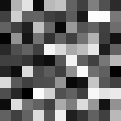

In [12]:
from PIL import Image
#roi.autoencoder()
idx = 4
_,decoded = roi.autoencoder(ds2.__getitem__(idx)['image'])
image = Image.fromarray( np.reshape(decoded.detach().numpy()*255, (11,11)), mode='L')
image2 = Image.fromarray( np.reshape(ds2.__getitem__(idx)['image'].numpy()*255, (11,11)), mode='L')
image.resize((121,121))

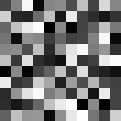

In [13]:
image2.resize((121,121))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.transforms import Compose
import transform_classes

csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'
compose1 = Compose([transform_classes.ReScale64(),transform_classes.StandardScale(),transform_classes.ToTensor()])
compose2 = Compose([transform_classes.ReScale32(),transform_classes.ToTensor()])
ds = RoiDataset(csv_file, compose1, compose2)

roi = RoiLearn()
roi.build_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(roi.model.parameters(), lr=0.1)

dataset_loader = torch.utils.data.DataLoader(ds,batch_size=32, shuffle=True,num_workers=0)